In [1]:
from sklearn.datasets import load_sample_image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import keras
import os
import pandas as pd  

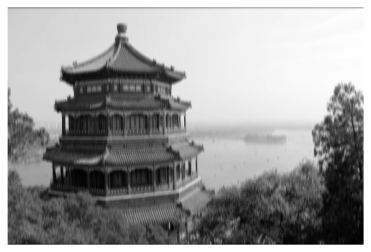

In [36]:
# 加载样本图片
#在 TensorFlow 中，每张输入图片通常都是用形状为[高度，宽度，通道]的 3D 张量表示的。
#一个小批次则为 4D 张量，形状是[批次大小，高度，宽度，通道]
#本例中，images.shape=(2, 427, 640, 3)

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape


# 创建两个过滤器
#卷积层的权重是 4D 张量，形状是[f[h], f[w], f[n'], f[n]]。
#卷积层的偏置项是 1D 张量，形状是[f[n]]。
#本例中，感受野7*7，3个RGB颜色通道，2个过滤器
#一个有垂直正中白线，另一个有水平正中白线
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 垂直线
filters[3, :, :, 1] = 1  # 水平线

#零填充（padding="same"），步长是 1。
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 0],cmap="grey") # 画出第 1 张图的第 1 个特征映射
plt.axis("off")
plt.show()

In [39]:
#keras 卷积层示例
#32 个过滤器的Conv2D层，每个过滤器的形状是3 × 3，步长为 1（水平垂直都是 1），
#"same"填充，输出使用 ReLU 激活函数。
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="same", activation="relu") 

#降低内存tips
#降低批次大小，使用步长降低纬度，去掉几层卷积层，使用 16 位浮点数，而不是 32 位浮点数
#或者，可以将 CNN 分布在多台设备上，分布式训练。

#池化层,核是2 × 2。步长默认等于核的大小
max_pool = keras.layers.MaxPool2D(pool_size=2) 
avg_pool = keras.layers.AvgPool2D(pool_size=2)
#全局平均池化层
global_avg_pool = keras.layers.GlobalAvgPool2D() 

In [37]:
#Keras 没有深度方向最大池化层，需使用 TensorFlow 低级 API tf.nn.max_pool()
#指定核的大小、步长（4 元素的元组）：元组的前三个值应该是 1，表明沿批次、高度、宽度的步长是 1；
#最后一个值，是深度方向的步长，深度步长必须可以整除输入深度

In [2]:
#exercise 14.5 用CNN 处理 Fashion MNIST 数据集

mnist=keras.datasets.mnist.load_data()
X_train,y_train =mnist[0][0][:50000]/255.,mnist[0][1][:50000]
X_val,y_val =mnist[0][0][50000:]/255.,mnist[0][1][50000:]
run_index = 1 

In [3]:
#随着 CNN 向着输出层的靠近，过滤器的数量一直在提高（一开始是 64，然后是 128，然后是 256）

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same",
                        input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(), #压平，全连接
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         2

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join("save_models","my_cnnmnist_model.h5"), 
                                                      save_best_only=True)
run_logdir = os.path.join("my_logs","my_cnnmnist_logs_run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
run_index =run_index+ 1 # increment every time you train the model

history=  model.fit(X_train, y_train, epochs=100,batch_size=1024,
          validation_data=(X_val, y_val),
          callbacks=callbacks)


Epoch 1/100
49/49 [==============================] - 212s 4s/step - loss: 1.0747 - accuracy: 0.6380 - val_loss: 0.1575 - val_accuracy: 0.9523
Epoch 2/100


C:\Users\sec_zca9cu_rw\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 208s 4s/step - loss: 0.1795 - accuracy: 0.9471 - val_loss: 0.0831 - val_accuracy: 0.9756
Epoch 3/100
49/49 [==============================] - 208s 4s/step - loss: 0.1056 - accuracy: 0.9694 - val_loss: 0.0607 - val_accuracy: 0.9820
Epoch 4/100
49/49 [==============================] - 207s 4s/step - loss: 0.0768 - accuracy: 0.9783 - val_loss: 0.0571 - val_accuracy: 0.9833
Epoch 5/100
49/49 [==============================] - 209s 4s/step - loss: 0.0575 - accuracy: 0.9828 - val_loss: 0.0444 - val_accuracy: 0.9865
Epoch 6/100
49/49 [==============================] - 209s 4s/step - loss: 0.0515 - accuracy: 0.9849 - val_loss: 0.0401 - val_accuracy: 0.9885
Epoch 7/100
49/49 [==============================] - 209s 4s/step - loss: 0.0430 - accuracy: 0.9877 - val_loss: 0.0347 - val_accuracy: 0.9899
Epoch 8/100
49/49 [==============================] - 208s 4s/step - loss: 0.0323 - accuracy: 0.9905 - val_loss: 0.0356 - val_accuracy: 0.9899
Epoch 9/100
49/49 

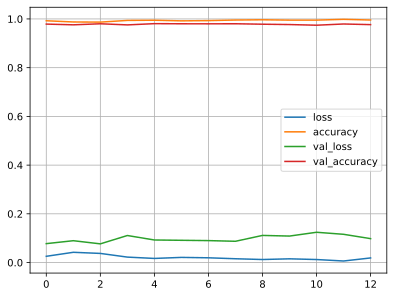

313/313 - 10s - loss: 0.0767 - accuracy: 0.9802 - 10s/epoch - 33ms/step


[0.07673460990190506, 0.9801999926567078]

In [16]:
pd.DataFrame(history.history).plot()  
plt.grid(True)
plt.show()
model=keras.models.load_model(os.path.join("save_models","my_cnnmnist_model.h5"))
model.evaluate(X_val,y_val,verbose=2)

In [47]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

[X_train_full,y_train_full],[X_valid,y_valid]=keras.datasets.cifar10.load_data()
shuffle_index=np.random.randint( 1,50000, size = 5000 ) 
X_train,y_train=X_train_full[shuffle_index] ,y_train_full[shuffle_index]

model = keras.models.Sequential([
    keras.layers.Conv2D(96, 7, activation="relu", padding="same",
                        input_shape=[32, 32, 3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(384, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(384, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(), #压平，全连接
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

#run_index=0

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 96)        14208     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       221440    
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 384)         8

In [48]:
run_index =run_index+ 1 # increment every time you train the model

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join("save_models","my_cnncifar_model.h5"), 
                                                      save_best_only=True)
run_logdir = os.path.join("my_logs","my_cnncifar_logs_run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]


history=  model.fit(X_train, y_train, epochs=100,batch_size=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)


Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 2.8472 - accuracy: 0.1674

C:\Users\sec_zca9cu_rw\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 93s 2s/step - loss: 2.8472 - accuracy: 0.1674 - val_loss: 2.0857 - val_accuracy: 0.2663
Epoch 2/100
50/50 [==============================] - 90s 2s/step - loss: 1.9014 - accuracy: 0.3062 - val_loss: 1.6741 - val_accuracy: 0.3839
Epoch 3/100
50/50 [==============================] - 91s 2s/step - loss: 1.7024 - accuracy: 0.3736 - val_loss: 1.5718 - val_accuracy: 0.4394
Epoch 4/100
50/50 [==============================] - 91s 2s/step - loss: 1.5683 - accuracy: 0.4286 - val_loss: 1.5221 - val_accuracy: 0.4505
Epoch 5/100
50/50 [==============================] - 91s 2s/step - loss: 1.4296 - accuracy: 0.4748 - val_loss: 1.3840 - val_accuracy: 0.5014
Epoch 6/100
50/50 [==============================] - 91s 2s/step - loss: 1.3018 - accuracy: 0.5278 - val_loss: 1.3687 - val_accuracy: 0.5010
Epoch 7/100
50/50 [==============================] - 91s 2s/step - loss: 1.1521 - accuracy: 0.5876 - val_loss: 1.3351 - val_accuracy: 0.5145
Epoch 8/100
50/50 [======

KeyboardInterrupt: 

## 用xception 预训练 tf_flowers数据集

In [25]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
info.splits
#只有"train"训练集，没有测试集和验证集，所以需要分割训练集。

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [47]:
train_set,valid_set,test_set = tfds.load("tf_flowers", 
                                         split=["train[:75%]", "train[75%:90%]", "train[:10%]"],
                                         as_supervised=True)
print("train_set:",len(list(train_set)))
print("valid_set:",len(list(valid_set)))
print("test_set:",len(list(test_set)))

train_set: 2752
valid_set: 551
test_set: 367


In [48]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1) 